<div style="display: flex; align-items: center;">
    <img src="https://github.com/nagelt/Teaching_Scripts/raw/9d9e29ecca4b04eaf7397938eacbf116d37ddc93/Images/TUBAF_Logo_blau.png" width="500" height="auto" height="auto" style="margin-right: 100px;" />
    <div>
        <p><strong>Prof. Dr. Thomas Nagel</strong></p>
        <p>Chair of Soil Mechanics and Foundation Engineering<br>Geotechnical Institute<br>Technische Universität Bergakademie Freiberg.</p>
        <p><a href="https://tu-freiberg.de/en/soilmechanics">https://tu-freiberg.de/en/soilmechanics</a></p>
    </div>
</div>

In [269]:
import numpy as np
import matplotlib.pyplot as plt

#Some plot settings
%run plot_functions/plot_settings.py

# Exercise 6 - Geometrically non-linear FEM: soil column under gravity and top load

## Weak forms

$$
    \int \limits_{\Omega_0} \mathbf{S:}\delta\mathbf{E}\,\text{d}\Omega_0 = \int \limits_{\Omega_0} \varrho_0 \mathbf{b}\cdot\delta\mathbf{u}\,\text{d}\Omega_0 + \int \limits_{\partial\Omega_0} \bar{\mathbf{t}}\cdot\delta\mathbf{u}\,\text{d}\Gamma_0
$$

## Linearization

$$
	\int \limits_{\Omega^{0}} \left[ {}^{i-1}{\mathbf{S}}^{t+\Delta t} \mathbf{:} {}^{i}{\Delta \delta \mathbf{E}}{} + {}^{i-1}{\delta \mathbf{E}}^{t+\Delta t} \mathbf{:} {}^{i-1}{\boldsymbol{\mathcal{C}}_m}^{t+\Delta t} \mathbf{:} {}^{i}{\Delta \mathbf{E}}{} \right] \,\text{d} \Omega^{0} = f^{t+\Delta t} - \int \limits_{\Omega^{0}} {}^{i-1}{\mathbf{S}}^{t+\Delta t} \mathbf{:} {}^{i-1}{\delta \mathbf{E}}^{t + \Delta t} \,\text{d} \Omega^{0} = {}^{i-1}{\boldsymbol{\Psi}}{}
$$

## Discretization

\begin{align}
 \left[ \int \limits_{\Omega^{0}} {}^{i-1}{\mathbb{B}^\text{T}}^{t+\Delta t} {} {}^{i-1}{\mathbb{D}_\text{M}}^{t+\Delta t} {}^{i-1}{\mathbb{B}}^{t+\Delta t} \,\text{d} \Omega^{0} + \int \limits_{\Omega^{0}} \mathbb{G}^\text{T} {}^{i-1}{\mathbb{S}}^{t+\Delta t}\mathbb{G} \,\text{d} \Omega^{0}\right] {}^{i}{\Delta \underline{u}}{} &= \underline{F}^{t+\Delta t} - \int \limits_{\Omega^{0}} {}^{i-1}{\mathbb{B}^\text{T}}^{t+\Delta t} {}^{i-1}{\underline{S}}^{t+\Delta t} \,\text{d} \Omega^{0}\\
 ( {}^{i-1}{\mathbb{K}_\text{M}}^{t+\Delta t} + {}^{i-1}{\mathbb{K}_\text{G}}^{t+\Delta t} ) {}^{i}{\Delta \underline{u}}{} &= {}^{i-1}{\underline{\Psi}}{}
\end{align}


## Discrete linearized problem in 1D

We stick with Saint-Venant-Kirchhoff and thus can write $S_{11} = E E_{11}$ with the Young's modulus $E$. The Green-Lagrange strain coordinate is given as

$$
    E_{11} = \frac{1}{2} \left[ (F_{11}^2 - 1 \right] \qquad F_{11} = 1 + u_{1,1}
$$

The only relevant gradient matrix entries are the vectors

$$
    \mathbb{G} = [N_{,1}^1 \dots N_{,1}^n] = \nabla N \qquad \mathbb{B} = [F_{11}N_{,1}^1 \dots F_{11}N_{,1}^n] \qquad \mathbb{S} = S_{11}
$$


## Finite elements in 1D

We have a soil column of $H=20$ m on top of the bed rock at $z=0$.

We first create an element class. An element knows the number of nodes it has, their IDs in the global node vector, and the coordinates of its nodes. Linear elements have 2 nodes and 2 quadrature points, quadratic elements 3 nodes and 3 quadrature points. The natural coordinates of the element run from -1 to 1, and the quadrature points and weights are directly taken from Numpy.

In [270]:
#element class
class line_element():#local coordinates go from -1 to 1
    #takes number of nodes, global nodal coordinates, global node ids
    def __init__(self, nnodes=2, ncoords=[0.,1.], nids=[0,1]):
        self.__nnodes = nnodes
        if (len(ncoords) != self.__nnodes):
            raise Exception("Number of coordinates does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(ncoords)))
        else:
            self.__coords = np.array(ncoords)
        
        self.__natural_coords = (self.__coords-self.__coords[0])/(self.__coords[-1]-self.__coords[0])*2. - 1.
        
        if (len(nids) != self.__nnodes):
            raise Exception("Number of node IDs does not match number \
                            of nodes of element (%i vs of %i)" %(self.__nnodes,len(nids)))
        else:
            self.__global_ids = np.array(nids)
        self.__quad_degree = self.__nnodes
        self.__quad_points, self.__quad_weights = np.polynomial.legendre.leggauss(self.__quad_degree)
                

Next, we wish to generate a one-dimensional mesh by specifying the length of a line, the number of elements into which the mesh is to be split, and the number of nodes per element.

In [271]:
def number_of_nodes(nelems,nodes_per_elem):
    return nelems*nodes_per_elem - (nelems - 1)

def generate_mesh(domain_length,nelems,nodes_per_elem):
    nn = number_of_nodes(nelems,nodes_per_elem)
    #coordinate vector of global nodes
    global_nodal_coordinates = np.linspace(0.,domain_length,nn)
    global_solution = np.array([0.]*nn)
    
    #generate elements
    element_vector = []
    for i in range(nelems):
        node_start = (nodes_per_elem-1)*i
        element_vector.append(
            line_element(nodes_per_elem,
                         global_nodal_coordinates[node_start:node_start+nodes_per_elem],
                         list(range(node_start,node_start+nodes_per_elem))))
        
    return global_nodal_coordinates, element_vector, global_solution

Let's put this to test.

In [272]:
number_of_elements = 30
L = 10.
nodes_per_element = 3

nodes,elements,solution=generate_mesh(L,number_of_elements,nodes_per_element)

In [273]:
#N
def shape_function(element_order,xi):
    if (element_order == 2): #-1,1
            return np.array([(1.-xi)/2., (1.+xi)/2.])
    elif (element_order == 3): #-1, 0, 1
            return np.array([(xi - 1.)*xi/2., (1-xi)*(1+xi), (1+xi)*xi/2.])
#dN_dxi
def dshape_function_dxi(element_order,xi):
    if (element_order == 2): #-1,1
        return np.array([-0.5*xi/xi, 0.5*xi/xi])  #xi only later for plotting dimensions
    elif (element_order == 3):#-1,0,1
        return np.array([xi - 0.5,-2.*xi,xi + 0.5])

#dz_dxi
def element_jacobian(element,xi):
    element_order = element._line_element__nnodes
    Jacobian = 0.
    Jacobian += dshape_function_dxi(element_order,xi).dot(element._line_element__coords)
    return Jacobian

#dN_dz
def grad_shape_function(element,xi):
    element_order = element._line_element__nnodes
    Jac = element_jacobian(element,xi)
    return dshape_function_dxi(element_order,xi)/Jac


## Local assember

In [274]:
def Stiffness(z):
    E0 = 1.e6 #Pa
    return E0

def Density(z):
    rho0 = 2600.*(1.-0.38) #kg/m³
    return rho0

def BodyForce(z):#N/m
    g = -9.81
    return g*Density(z)

In [275]:
def local_assembler(elem,el_sol):
    element_order = elem._line_element__nnodes
    K_loc = np.zeros((element_order,element_order))
    b_loc = np.zeros(element_order)
    z_nodes = elem._line_element__coords
    for i in range(elem._line_element__quad_degree):
        #local integration point coordinate
        xi = elem._line_element__quad_points[i]
        #shape function
        N = shape_function(element_order,xi)
        #gradient of shape function
        dN_dX = grad_shape_function(elem,xi)
        #determinant of Jacobian
        detJ = np.abs(element_jacobian(elem,xi))
        #integration weight
        w = elem._line_element__quad_weights[i]
        
        #global integration point coordinate (for spatially varying properties)
        z_glob = np.dot(N,z_nodes)
        #evaluation of local material/structural properties
        E = Stiffness(z_glob)
        #evaluation of local body force
        rho_g = BodyForce(z_glob)
        
        grad_u = np.dot(dN_dX,el_sol)
        F_11 = grad_u + 1
        if (F_11 <= 0):
            print("element collapse")
        E_11 = (F_11*F_11 - 1)/2
        
        S_11 = E*E_11
        
        #assembly of local stiffness matrix
        #K_loc += np.outer(dN_dX,dN_dX) * E * w * detJ
        K_T = (F_11*F_11*E + S_11)
        K_loc += np.outer(dN_dX,dN_dX) * K_T  * w * detJ
        
        if K_T < 0:
            print("Negative tangent stiffness entry.")
        
        #assembly of local RHS
        b_loc += (F_11*np.dot(dN_dX,S_11) - N * rho_g) * w * detJ
    return K_loc,b_loc

## Global assembly

Now we can construct the global matrix system $\mathbf{K}\mathbf{u} = \mathbf{f}$ or $\mathbf{A}\mathbf{x}=\mathbf{b}$ (see lecture script).

In [276]:
def global_assembler(nodes,elements,solution):
    K_glob = np.zeros((len(nodes),len(nodes)))
    b_glob = np.zeros(len(nodes))
    for i,elem in enumerate(elements):
        start_id = elem._line_element__global_ids[0]
        end_id = elem._line_element__global_ids[-1]
        K_i, b_i = local_assembler(elem,solution[start_id:end_id+1])
        K_glob[start_id:end_id+1,start_id:end_id+1] += K_i
        b_glob[start_id:end_id+1] += b_i
    return K_glob, b_glob

In [277]:
def apply_Neumann_bc(b_glob,node_id,value):
    b_glob[node_id] -= value
    return b_glob

In [278]:
#adapted to incremental scheme
def apply_Dirichlet_bc(K_glob,b_glob,solution,node_id,value):
    K_glob[node_id,:] = 0.# = K_glob[:,node_id] = 0.
    K_glob[node_id,node_id] = 1.
    b_glob[node_id] = 0 #no increment
    solution[node_id] = value
    return K_glob, b_glob, solution

## Problem solution

We now perform the global assembly, apply a vanishing traction on the top and constrain the displacement at the bottom to zero.

In [279]:
number_of_elements = 20
L = 10.
nodes_per_element = 2

nodes,elements,solution=generate_mesh(L,number_of_elements,nodes_per_element)

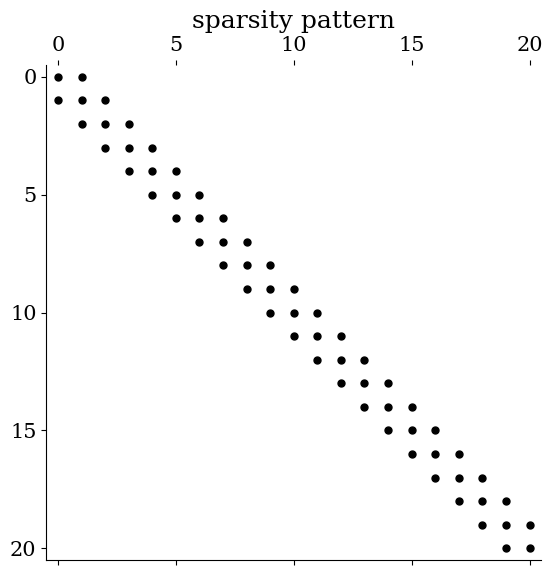

In [280]:
K, f = global_assembler(nodes,elements,solution)
plt.spy(K,marker='.')
plt.title('sparsity pattern')
plt.tight_layout()

In [281]:
def residual_and_K_eval(nodes,elements,solution,sig_top):
    K, f = global_assembler(nodes,elements,solution)
    f = apply_Neumann_bc(f,len(nodes)-1,sig_top)
    return K, f

In [282]:
def newton_solve(nodes,elements,solution,sig_top=0, u_bot = 0):
    tol = 1e-6
    iters = 0
    K, f = residual_and_K_eval(nodes,elements,solution,sig_top)
    K, f, solution = apply_Dirichlet_bc(K, f, solution, 0, u_bot)
    inc = np.linalg.solve(K,-f)
    solution += inc
    err = np.linalg.norm(f)/len(elements)
    while iters < 20:
        K, f = residual_and_K_eval(nodes,elements,solution,sig_top)#
        K, f, solution = apply_Dirichlet_bc(K, f, solution, 0, u_bot)
        err = np.linalg.norm(f)/len(elements)
        if (err <= tol):
            break
        inc = np.linalg.solve(K,-f)
        solution += inc
        iters += 1
    print("Converged in %i iterations" %iters)
    return solution

In [283]:
nodes,elements,solution=generate_mesh(L,number_of_elements,nodes_per_element)
solution = newton_solve(nodes,elements,solution,-5e3,0)

Converged in 4 iterations


In [284]:
reference_z = np.linspace(0,L,100)
reference_solution = ((reference_z/L)**2 - 2.*reference_z/L) * BodyForce(0) * L**2 / (2.*Stiffness(0))-1

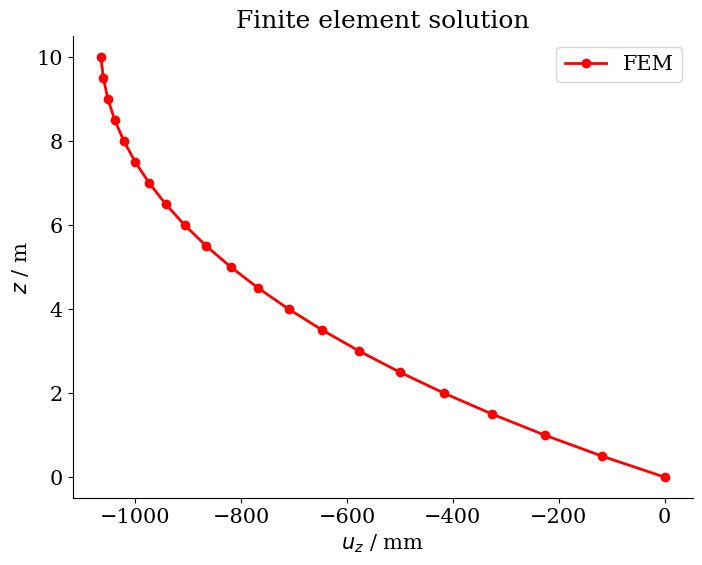

In [285]:
plt.ylabel('$z$ / m')
plt.xlabel('$u_z$ / mm')
plt.title('Finite element solution')
plt.plot(solution*1e3, nodes, 'ro-', label='FEM')
#plt.plot(reference_solution*1e3, reference_z, ls='--', color='black', label='load-free, small strain')
plt.legend();

 $$
     K_\text{T} = F_{11}^2 E + S_{11} = F_{11}^2 E + E \frac{F_{11}^2- 1}{2} = E \left[ \frac{3}{2} F_{11}^2 - \frac{1}{2} \right]
 $$
 
 $K_\text{T} = 0$ für 
 
 $$
     F_{11} = \frac{1}{\sqrt{3}}
 $$
 
 bzw.
 
 $$
     u_{1,1} = \frac{1}{\sqrt{3}} - 1
 $$
 
 Außerdem: $F_{11} < 0$ für $\Delta u_z(z=0) > \Delta z$.
 

In [286]:
du = elements[0]._line_element__coords[1]*(1/np.sqrt(3)-1)
print(du)
print(1/np.sqrt(3))

-0.21132486540518708
0.5773502691896258


Running with u_z(z=0) = 1000.0 mm
element collapse
element collapse
element collapse
element collapse
element collapse
element collapse
element collapse
element collapse
element collapse
element collapse
Converged in 4 iterations
Running with u_z(z=0) = 200.0 mm
Negative tangent stiffness entry.
Negative tangent stiffness entry.
Negative tangent stiffness entry.
Negative tangent stiffness entry.
Negative tangent stiffness entry.
Negative tangent stiffness entry.
Negative tangent stiffness entry.
Negative tangent stiffness entry.
Negative tangent stiffness entry.
Negative tangent stiffness entry.
Converged in 4 iterations
Running with u_z(z=0) = 100.0 mm
Converged in 6 iterations
Running with u_z(z=0) = 0.0 mm
Converged in 4 iterations
Running with u_z(z=0) = -200.0 mm
Converged in 6 iterations
Running with u_z(z=0) = -1000.0 mm
Converged in 9 iterations


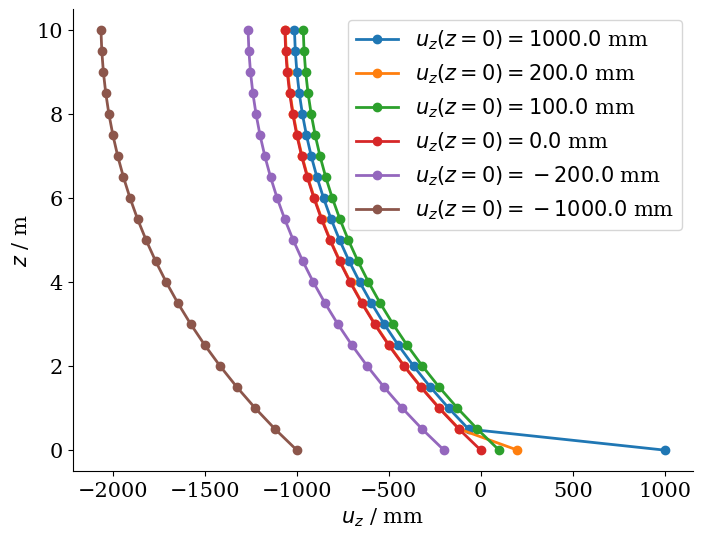

In [287]:
plt.ylabel('$z$ / m')
plt.xlabel('$u_z$ / mm')
for i in [1,0.2,0.1,0,-0.2,-1]:
    print("Running with u_z(z=0) = %.1f mm" %(i*1e3))
    nodes,elements,solution=generate_mesh(L,number_of_elements,nodes_per_element)
    solution = newton_solve(nodes,elements,solution,-5e3,i)
    plt.plot(solution*1e3, nodes, marker='o', label='$u_z(z=0) = %.1f$ mm' %(i*1e3))
plt.legend();

Wir modifizieren die lokalen Assembler (Steifigkeitsmatrix).

In [288]:
def local_assembler(elem,el_sol):
    element_order = elem._line_element__nnodes
    K_loc = np.zeros((element_order,element_order))
    b_loc = np.zeros(element_order)
    z_nodes = elem._line_element__coords
    for i in range(elem._line_element__quad_degree):
        #local integration point coordinate
        xi = elem._line_element__quad_points[i]
        #shape function
        N = shape_function(element_order,xi)
        #gradient of shape function
        dN_dX = grad_shape_function(elem,xi)
        #determinant of Jacobian
        detJ = np.abs(element_jacobian(elem,xi))
        #integration weight
        w = elem._line_element__quad_weights[i]
        
        #global integration point coordinate (for spatially varying properties)
        z_glob = np.dot(N,z_nodes)
        #evaluation of local material/structural properties
        E = Stiffness(z_glob)
        #evaluation of local body force
        rho_g = BodyForce(z_glob)
        
        grad_u = np.dot(dN_dX,el_sol)
        F_11 = grad_u + 1
        if (F_11 <= 0.):
            print("penetration unsolved")
  
        E_11 = (F_11*F_11 - 1)/2
        
        S_11 = E*E_11
        
        #assembly of local stiffness matrix
        #K_loc += np.outer(dN_dX,dN_dX) * E * w * detJ
        K_T = (F_11*F_11*E + S_11)
        
        if K_T < 0:
            K_T = F_11**2*E
            print("negative tangent fix")
        K_loc += np.outer(dN_dX,dN_dX) * K_T  * w * detJ
        
        #assembly of local RHS
        b_loc += (F_11*np.dot(dN_dX,S_11) - N * rho_g) * w * detJ
    return K_loc,b_loc

Running with u_z(z=0) = 1000.0 mm
penetration unsolved
penetration unsolved
penetration unsolved
penetration unsolved
penetration unsolved
penetration unsolved
penetration unsolved
penetration unsolved
penetration unsolved
penetration unsolved
Converged in 4 iterations
Running with u_z(z=0) = 200.0 mm
negative tangent fix
negative tangent fix
negative tangent fix
negative tangent fix
Converged in 8 iterations
Running with u_z(z=0) = 100.0 mm
Converged in 6 iterations
Running with u_z(z=0) = 0.0 mm
Converged in 4 iterations
Running with u_z(z=0) = -200.0 mm
Converged in 6 iterations
Running with u_z(z=0) = -1000.0 mm
Converged in 9 iterations


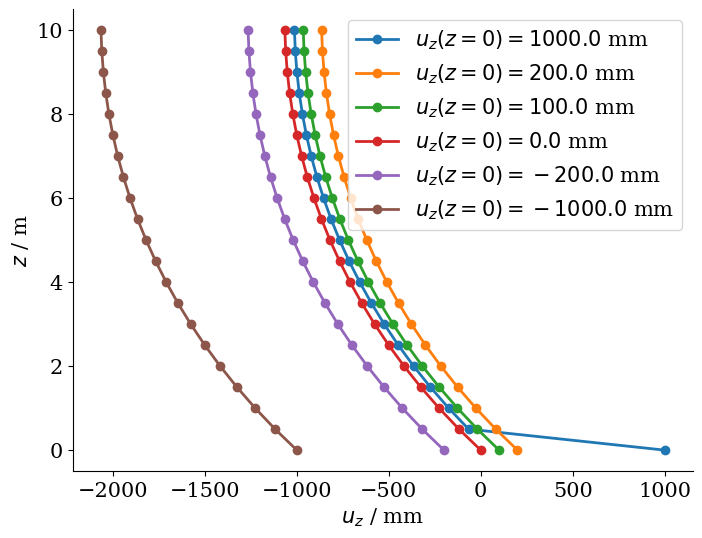

In [289]:
plt.ylabel('$z$ / m')
plt.xlabel('$u_z$ / mm')
for i in [1,0.2,0.1,0,-0.2,-1]:
    print("Running with u_z(z=0) = %.1f mm" %(i*1e3))
    nodes,elements,solution=generate_mesh(L,number_of_elements,nodes_per_element)
    solution = newton_solve(nodes,elements,solution,-5e3,i)
    plt.plot(solution*1e3, nodes, marker='o', label='$u_z(z=0) = %.1f$ mm' %(i*1e3))
plt.legend();

This only helped in the orange case.

We do a trick with the initial guess following the bc application. Here, we just shift the entire mesh in the first iteration instead of only the first node. After that, everything proceeds as normal. We could also do this via influence functions (interpolating between all Dirichlet bc).

In [290]:
def local_assembler(elem,el_sol):
    element_order = elem._line_element__nnodes
    K_loc = np.zeros((element_order,element_order))
    b_loc = np.zeros(element_order)
    z_nodes = elem._line_element__coords
    for i in range(elem._line_element__quad_degree):
        #local integration point coordinate
        xi = elem._line_element__quad_points[i]
        #shape function
        N = shape_function(element_order,xi)
        #gradient of shape function
        dN_dX = grad_shape_function(elem,xi)
        #determinant of Jacobian
        detJ = np.abs(element_jacobian(elem,xi))
        #integration weight
        w = elem._line_element__quad_weights[i]
        
        #global integration point coordinate (for spatially varying properties)
        z_glob = np.dot(N,z_nodes)
        #evaluation of local material/structural properties
        E = Stiffness(z_glob)
        #evaluation of local body force
        rho_g = BodyForce(z_glob)
        
        grad_u = np.dot(dN_dX,el_sol)
        F_11 = grad_u + 1
        if (F_11 <= 0):
            print("element collapse")
        E_11 = (F_11*F_11 - 1)/2
        
        S_11 = E*E_11
        
        #assembly of local stiffness matrix
        #K_loc += np.outer(dN_dX,dN_dX) * E * w * detJ
        K_T = (F_11*F_11*E + S_11)
        K_loc += np.outer(dN_dX,dN_dX) * K_T  * w * detJ
        
        if K_T < 0:
            print("Negative tangent stiffness entry.")
        
        #assembly of local RHS
        b_loc += (F_11*np.dot(dN_dX,S_11) - N * rho_g) * w * detJ
    return K_loc,b_loc

In [291]:
def newton_solve(nodes,elements,solution,sig_top=0, u_bot = 0):
    tol = 1e-6
    iters = 0
    K, f = residual_and_K_eval(nodes,elements,solution,sig_top)
    for j in range(len(nodes)):
        K, f, solution = apply_Dirichlet_bc(K, f, solution, j, u_bot)
    inc = np.linalg.solve(K,-f)
    solution += inc
    err = np.linalg.norm(f)/len(elements)
    while iters < 20:
        K, f = residual_and_K_eval(nodes,elements,solution,sig_top)#
        K, f, solution = apply_Dirichlet_bc(K, f, solution, 0, u_bot)
        err = np.linalg.norm(f)/len(elements)
        if (err <= tol):
            break
        inc = np.linalg.solve(K,-f)
        solution += inc
        iters += 1
    print("Converged in %i iterations" %iters)
    return solution

Running with u_z(z=0) = 1000.0 mm
Converged in 5 iterations
Running with u_z(z=0) = 200.0 mm
Converged in 5 iterations
Running with u_z(z=0) = 100.0 mm
Converged in 5 iterations
Running with u_z(z=0) = 0.0 mm
Converged in 5 iterations
Running with u_z(z=0) = -200.0 mm
Converged in 5 iterations
Running with u_z(z=0) = -1000.0 mm
Converged in 5 iterations


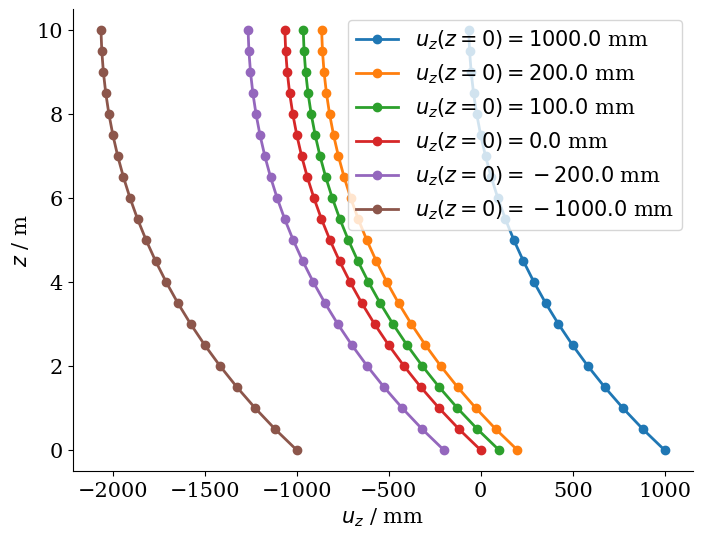

In [292]:
plt.ylabel('$z$ / m')
plt.xlabel('$u_z$ / mm')
for i in [1,0.2,0.1,0,-0.2,-1]:
    print("Running with u_z(z=0) = %.1f mm" %(i*1e3))
    nodes,elements,solution=generate_mesh(L,number_of_elements,nodes_per_element)
    solution = newton_solve(nodes,elements,solution,-5e3,i)
    plt.plot(solution*1e3, nodes, marker='o', label='$u_z(z=0) = %.1f$ mm' %(i*1e3))
plt.legend();

This adds one additional iteration here ... 

One could also look at the solution vector after setting the bc and apply a smoother based on discretization size for improving the initial guess.